## **Assignment 1 - n-gram Language Models**

<b><u>Contributors</u></b>: Dimitris Vougioukos - f3352411, Ioannis Papadopoulos - f3352409


<b><u>Contribution</u></b>: Dimitris Vougioukos: 1,2,3,4,5,6 - Ioannis Papadopoulos: 1,2,3

The following is the implementation of the first assignment of the Text Analytics course concerning the n-gram language models

### **Task 1 - Task 2**

Import and download some required packages

In [1]:
# Installing necessary libraries
!pip install -q python-Levenshtein evaluate jiwer

# Importing required libraries
import nltk
import random
import math
import re
import numpy as np
import heapq
import Levenshtein
import matplotlib.pyplot as plt
from itertools import chain
from collections import Counter
from sklearn.model_selection import KFold
from nltk.corpus import reuters
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.util import ngrams
from evaluate import load
from tabulate import tabulate

# Downloading NLTK corpus and tokenizer
nltk.download("reuters")
nltk.download("punkt")
nltk.download("punkt_tab")

# Load evaluation metrics
cer = load("cer")
wer = load("wer")

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Explore the Reuters corpus

In [2]:
# Getting all the file ids
file_ids = reuters.fileids()

# Printing 5 random file ids
print(f"Five random file ids of the corpus:\n {random.sample(file_ids, 5)}\n")

# Getting the distinct file types
file_types = set(file_id.split("/")[0] for file_id in file_ids)

print(f"Distinct file types:\n {file_types}")

Five random file ids of the corpus:
 ['training/3425', 'training/307', 'training/7939', 'test/15963', 'training/5286']

Distinct file types:
 {'training', 'test'}


Division of the corpus into training and testing subsets

In [3]:
# Initializing two lists containing the raw training and test texts
train_raw_texts, test_raw_texts = [], []

# Iterating over the files
for file_id in file_ids:

  # Checking the file type
  if file_id.startswith("training/"):

    # Updating the training list
    train_raw_texts.append(reuters.raw(file_id))

  else:

    # Updating the test list
    test_raw_texts.append(reuters.raw(file_id))

# Concatenating all the texts
train_raw_text = " ".join(train_raw_texts)
test_raw_text = " ".join(test_raw_texts)

# Getting the training and test sentences from the texts
train_sentences = sent_tokenize(train_raw_text)
test_sentences = sent_tokenize(test_raw_text)

print(f"Total training sentences: {len(train_sentences)}")
print(f"Two sentences from the training subset:\n {train_sentences[:2]}\n")
print(f"Total test sentences: {len(test_sentences)}")
print(f"Two sentences from the test subset:\n {test_sentences[:2]}")

Total training sentences: 37700
Two sentences from the training subset:
 ['BAHIA COCOA REVIEW\n  Showers continued throughout the week in\n  the Bahia cocoa zone, alleviating the drought since early\n  January and improving prospects for the coming temporao,\n  although normal humidity levels have not been restored,\n  Comissaria Smith said in its weekly review.', 'The dry period means the temporao will be late this year.']

Total test sentences: 13281
Two sentences from the test subset:
 ["ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT\n  Mounting trade friction between the\n  U.S. And Japan has raised fears among many of Asia's exporting\n  nations that the row could inflict far-reaching economic\n  damage, businessmen and officials said.", 'They told Reuter correspondents in Asian capitals a U.S.\n  Move against Japan might boost protectionist sentiment in the\n  U.S. And lead to curbs on American imports of their products.']


Word level tokenization

In [4]:
# Initializing two lists containing the training and test tokens
train_sentences_tokenized, test_sentences_tokenized = [], []

# Iterating over the training sentences
for train_sentence in train_sentences:

  # Tokenizing and updating the training list
  train_sentences_tokenized.append(word_tokenize(train_sentence.lower()))

# Iterating over the test sentenes
for test_sentence in test_sentences:

  # Tokenizing and updating the test list
  test_sentences_tokenized.append(word_tokenize(test_sentence.lower()))

print(f"Two tokenized sentences from the training subset:\n {train_sentences_tokenized[:2]}\n")
print(f"Two tokenized sentences from the test subset:\n {test_sentences_tokenized[:2]}")

Two tokenized sentences from the training subset:
 [['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'the', 'week', 'in', 'the', 'bahia', 'cocoa', 'zone', ',', 'alleviating', 'the', 'drought', 'since', 'early', 'january', 'and', 'improving', 'prospects', 'for', 'the', 'coming', 'temporao', ',', 'although', 'normal', 'humidity', 'levels', 'have', 'not', 'been', 'restored', ',', 'comissaria', 'smith', 'said', 'in', 'its', 'weekly', 'review', '.'], ['the', 'dry', 'period', 'means', 'the', 'temporao', 'will', 'be', 'late', 'this', 'year', '.']]

Two tokenized sentences from the test subset:
 [['asian', 'exporters', 'fear', 'damage', 'from', 'u.s.-japan', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'u.s.', 'and', 'japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'asia', "'s", 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far-reaching', 'economic', 'damage', ',', 'businessmen', 'and', 'officials', 'said', '.'], ['they', 'told', 'r

Get the frequency of the training and test tokens

In [5]:
# Getting all the training tokens
all_train_tokens = list(chain.from_iterable(train_sentences_tokenized))

# Counting the frequency of the training tokens
train_tokens_frequency = Counter(all_train_tokens)

print(f"Number of tokens in training subset: {len(all_train_tokens)}")
print(f"Number of unique tokens in training subset: {len(train_tokens_frequency)}")
print(f"10 most common tokens in training subset: \n {train_tokens_frequency.most_common(10)} \n")

# Getting all the test tokens
all_test_tokens = list(chain.from_iterable(test_sentences_tokenized))

# Counting the frequency of the test tokens
test_tokens_frequency = Counter(all_test_tokens)

print(f"Number of tokens in test subset: {len(all_test_tokens)}")
print(f"Number of unique tokens in test subset: {len(test_tokens_frequency)}")
print(f"10 most common tokens in test subset: \n {test_tokens_frequency.most_common(10)}")

Number of tokens in training subset: 1136318
Number of unique tokens in training subset: 41908
10 most common tokens in training subset: 
 [('the', 51383), (',', 39586), ('.', 37651), ('of', 27306), ('to', 27306), ('in', 22003), ('and', 18957), ('said', 18843), ('a', 18456), ('mln', 13089)] 

Number of tokens in test subset: 412952
Number of unique tokens in test subset: 25399
10 most common tokens in test subset: 
 [('the', 17862), (',', 14079), ('.', 13255), ('of', 9443), ('to', 8969), ('in', 7214), ('and', 6659), ('said', 6538), ('a', 6268), ('mln', 5509)]


Find the tokens in the training subset with frequency less than 5 and replace them in the entire corpus with the special token 'UNK'

In [6]:
# Finding the training tokens with frequency less than 5
rare_training_token = [
    token for token, frequency in train_tokens_frequency.items() if frequency < 5
]

print(
    "Total number of tokens that occur less than 5 times in training subset:"
       + f"{len(rare_training_token)}\n"
)
print(f"Five random tokens of this kind:\n {random.sample(rare_training_token, 5)}")

# Converting to set for faster replacements
rare_training_token = set(rare_training_token)

# Replacing these tokens with the special token 'UNK' in both subsets
train_sentences_tokenized = [
    ["UNK" if token in rare_training_token else token for token in sentence]
    for sentence in train_sentences_tokenized
]
test_sentences_tokenized = [
    ["UNK" if token in rare_training_token else token for token in sentence]
    for sentence in test_sentences_tokenized
]

Total number of tokens that occur less than 5 times in training subset:31407

Five random tokens of this kind:
 ['54.0', 'fraternite', '909,158', '289,433', '354,820']


Define a function to train the  bigram and trigram models by computing the frequency of all existed unigrams, bigrams and trigrams in the provided training subset

In [7]:
def train_lms(train_sentences):
    """
    This function used to train bigram and trigram models by computing the
    frequency of all existed unigrams, bigrams and trigrams in the provided
    training subset.

    :param train_sentences: A training subset of the corpus
    :return: The ngrams counters
    """

    # Initializing counters for the ngrams
    unigrams_frequency = Counter()
    bigrams_frequency = Counter()
    trigrams_frequency = Counter()

    # Iterating over the training sentences
    for sentence in train_sentences:

        # Updating the counters
        unigrams_frequency.update(
            [
                gram
                for gram in ngrams(
                    sentence,
                    1,
                    pad_left=True,
                    pad_right=True,
                    left_pad_symbol="<s>",
                    right_pad_symbol="<e>",
                )
            ]
        )
        bigrams_frequency.update(
            [
                gram
                for gram in ngrams(
                    sentence,
                    2,
                    pad_left=True,
                    pad_right=True,
                    left_pad_symbol="<s>",
                    right_pad_symbol="<e>",
                )
            ]
        )
        trigrams_frequency.update(
            [
                gram
                for gram in ngrams(
                    sentence,
                    3,
                    pad_left=True,
                    pad_right=True,
                    left_pad_symbol="<s>",
                    right_pad_symbol="<e>",
                )
            ]
        )

    # Adding the frequency of the combination ("<s>", "<s>")
    bigrams_frequency[("<s>", "<s>")] = len(train_sentences)

    return unigrams_frequency, bigrams_frequency, trigrams_frequency

Define two functions for calculating the probabilities in the bigram and trigram models

In [8]:
def calculate_bigram_prob(
    word_1,
    word_2,
    alpha_parameter,
    unigrams_frequency,
    bigrams_frequency,
    vocb_size
):
    """
    This function used to calculate the probability of the bigram model for two
    given words/tokens.

    :param word_1: The first word/token
    :param word_2: The second word/token
    :param alpha_parameter: The alpha parameter of the Laplace smoothing
    :param unigrams_frequency: The frequency of the unigrams
    :param bigrams_frequency: The frequency of the bigrams
    :param vocb_size: The size of the vocabulary
    :return: The bigram probability
    """

    # Finding the frequencies
    unigram_frequency = unigrams_frequency[(word_1,)]
    bigram_frequency = bigrams_frequency[(word_1, word_2)]

    # Calculating the bigram probability
    bigram_prob = (bigram_frequency + alpha_parameter) / (
        unigram_frequency + alpha_parameter * vocb_size
    )

    return bigram_prob


def calculate_trigram_prob(
    word_1,
    word_2,
    word_3,
    alpha_parameter,
    bigrams_frequency,
    trigrams_frequency,
    vocb_size,
):
    """
    This function used to calculate the probability of the trigram model for
    three given words/tokens.

    :param word_1: The first word/token
    :param word_2: The second word/token
    :param word_3: The third word/token
    :param alpha_parameter: The alpha parameter of the Laplace smoothing
    :param bigrams_frequency: The frequency of the bigrams
    :param trigrams_frequency: The frequency of the trigrams
    :param vocb_size: The size of the vocabulary
    :return: The trigram probability
    """

    # Finding the frequencies
    bigram_frequency = bigrams_frequency[(word_1, word_2)]
    trigram_frequency = trigrams_frequency[(word_1, word_2, word_3)]

    # Calculating the trigram probability
    trigram_prob = (trigram_frequency + alpha_parameter) / (
        bigram_frequency + alpha_parameter * vocb_size
    )

    return trigram_prob

Define two functions for illustrating the bigram and trigram models

In [9]:
def bigram_lm(
    sentence, alpha_parameter, unigrams_frequency, bigrams_frequency, vocb_size
):
    """
    This function used to illustrate the bigram model for a given sentence.

    :param sentence: The input sentence
    :param alpha_parameter: The alpha parameter of the Laplace smoothing
    :param unigrams_frequency: The frequency of the unigrams
    :param bigrams_frequency: The frequency of the bigrams
    :param vocb_size: The size of the vocabulary
    :return: The bigram log probability and the length of the sentence without the start token
    """

    # Initializing the variable to hold the summary of the log probabilities
    log_prob = 0

    # Adding start and end tokens
    sentence = ["<s>"] + sentence + ["<e>"]

    # Iterating over indices of the sentence
    for word_index in range(1, len(sentence)):

        # Getting two consecutive words
        word_1 = sentence[word_index - 1]
        word_2 = sentence[word_index]

        # Calculating the bigram probability
        bigram_prob = calculate_bigram_prob(
            word_1,
            word_2,
            alpha_parameter,
            unigrams_frequency,
            bigrams_frequency,
            vocb_size,
        )

        # Updating the summary
        log_prob += math.log2(bigram_prob)

    return log_prob, len(sentence) - 1


def trigram_lm(
    sentence, alpha_parameter, bigrams_frequency, trigrams_frequency, vocb_size
):
    """
    This function used to illustrate the trigram model for a given sentence.

    :param sentence: The input sentence
    :param alpha_parameter: The alpha parameter of the Laplace smoothing
    :param bigrams_frequency: The frequency of the bigrams
    :param trigrams_frequency: The frequency of the trigrams
    :param vocb_size: The size of the vocabulary
    :return: The trigram log probability and the length of the sentence without the start tokens
    """

    # Initializing the variable to hold the summary of the log probabilities
    log_prob = 0

    # Adding start and end tokens
    sentence = ["<s>"] + ["<s>"] + sentence + ["<e>"]

    # Iterating over the indices of the sentence
    for word_index in range(2, len(sentence)):

        # Getting three consecutive words
        word_1 = sentence[word_index - 2]
        word_2 = sentence[word_index - 1]
        word_3 = sentence[word_index]

        # Calculating the trigram probability
        trigram_prob = calculate_trigram_prob(
            word_1,
            word_2,
            word_3,
            alpha_parameter,
            bigrams_frequency,
            trigrams_frequency,
            vocb_size,
        )

        # Updating the summary
        log_prob += math.log2(trigram_prob)

    return log_prob, len(sentence) - 2

Define a function to calculate the cross-entropy and the perplexity of a model

In [10]:
def calculate_cross_entropy_perplexity(
    sentences, model, frequency_1, frequency_2, alpha_parameter, vocb_size
):
    """
    This function used to calculate the cross-entropy and the perplexity of a
    bigram or trigram language model.

    :param sentences: A subset of the corpus
    :param model: The language model
    :param frequency_1: The frequency of unigrams or bigrams
    :param frequency_2: The frequency of bigrams or trigrams
    :param alpha_parameter: The alpha parameter of the Laplace smoothing
    :param vocb_size: The size of the vocabulary
    :return: The cross-entropy and the perplexity of the model
    """

    # Initiliazing
    total_log_prob = 0
    total_words = 0

    # Iterating over the sentences
    for sentence in sentences:

        # Checking which model to use
        if model == "bigram":

            # Applying the bigram model on the sentence
            lob_prob, words = bigram_lm(
                sentence, alpha_parameter, frequency_1, frequency_2, vocb_size
            )

        else:

            # Applying the trigram model on the sentence
            lob_prob, words = trigram_lm(
                sentence, alpha_parameter, frequency_1, frequency_2, vocb_size
            )

        # Updating
        total_log_prob += lob_prob
        total_words += words

    # Calculating the cross-entropy and the perpplexity
    cross_entropy = -total_log_prob / total_words
    perplexity = math.pow(2, cross_entropy)

    return cross_entropy, perplexity

Fine-tune the alpha parameter of the Laplace smoothing method for both models and use the average perplexity metric to choose the best value

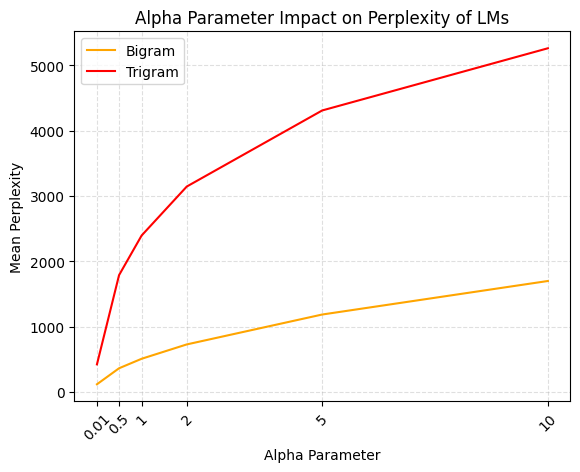


The best value of the alpha parameter in the bigram language model is 0.01 and its corresponding average perplexity is 120.1200
The best value of the alpha parameter in the trigram language model is 0.01 and its corresponding average perplexity is 424.7571


In [11]:
# Setting up the cross validation with 5 folds
cross_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Setting up the aplha values to test
alpha_parameter_values = [0.01, 0.5, 1, 2, 5, 10]

# Setting up the dictionaries to keep all the perplexity values of each alpha value
bigram_perplexities = {
    alpha_parameter_value: [] for alpha_parameter_value in alpha_parameter_values
}
trigram_perplexities = {
    alpha_parameter_value: [] for alpha_parameter_value in alpha_parameter_values
}

# Iterating over the folds
for train_indices, dev_indices in cross_validation.split(train_sentences_tokenized):

    # Splitting into training and development subsets
    train_sentences = [
        train_sentences_tokenized[train_index] for train_index in train_indices
    ]
    dev_sentences = [
        train_sentences_tokenized[dev_index] for dev_index in dev_indices
    ]

    # Getting the ngrams frequencies
    unigrams_frequency, bigrams_frequency, trigrams_frequency = train_lms(
        train_sentences
    )

    # Getting the vocabulary size
    vocb_size = len(unigrams_frequency)

    # Iterating over the alpha values
    for alpha_parameter_value in alpha_parameter_values:

        # Getting the perplexity of each model
        bigram_perplexities[alpha_parameter_value].append(
            calculate_cross_entropy_perplexity(
                dev_sentences,
                "bigram",
                unigrams_frequency,
                bigrams_frequency,
                alpha_parameter_value,
                vocb_size,
            )[1]
        )
        trigram_perplexities[alpha_parameter_value].append(
            calculate_cross_entropy_perplexity(
                dev_sentences,
                "trigram",
                bigrams_frequency,
                trigrams_frequency,
                alpha_parameter_value,
                vocb_size,
            )[1]
        )

# Getting the mean perplexity of each alpha value for both models
bigram_mean_perplexities = {
    key: np.mean(value) for key, value in bigram_perplexities.items()
}
trigram_mean_perplexities = {
    key: np.mean(value) for key, value in trigram_perplexities.items()
}

# Plotting mean perplexity for different values of alpha parameter
plt.plot(
    alpha_parameter_values,
    list(bigram_mean_perplexities.values()),
    label="Bigram",
    color="orange"
)
plt.plot(
    alpha_parameter_values,
    list(trigram_mean_perplexities.values()),
    label="Trigram",
    color="red",
)

# Adding plot elements
plt.xlabel("Alpha Parameter")
plt.ylabel("Mean Perplexity")
plt.title("Alpha Parameter Impact on Perplexity of LMs")
plt.xticks(alpha_parameter_values, alpha_parameter_values, rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.4)
plt.legend()

# Showing the plot
plt.show()

# Getting the alpha value with the minimum average perplexity for both models
best_bigram_alpha_parameter = min(
    bigram_mean_perplexities, key=bigram_mean_perplexities.get
)
best_trigram_alpha_parameter = min(
    trigram_mean_perplexities, key=trigram_mean_perplexities.get
)

print()
print(
    f"The best value of the alpha parameter in the bigram language model is {best_bigram_alpha_parameter} and its corresponding average perplexity is {bigram_mean_perplexities[best_bigram_alpha_parameter]:.4f}"
)
print(
    f"The best value of the alpha parameter in the trigram language model is {best_trigram_alpha_parameter} and its corresponding average perplexity is {trigram_mean_perplexities[best_trigram_alpha_parameter]:.4f}"
)

Train both models on the entire train subset using the best alpha values and compute their cross-entropy and perplexity values using the test subset of the corpus

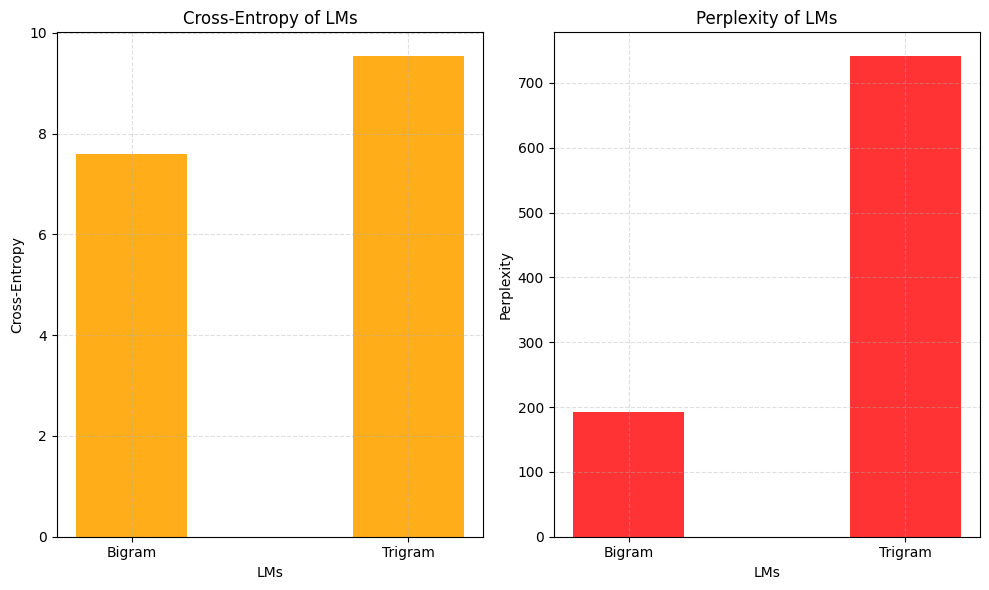


Bigram LM
Cross-Entropy: 7.5934
Perplexity: 193.1207

Trigram LM
Cross-Entropy: 9.5335
Perplexity: 741.1069


In [12]:
# Getting the ngrams frequencies
unigrams_frequency, bigrams_frequency, trigrams_frequency = train_lms(
    train_sentences_tokenized
)

# Getting the vocabulary size
vocb_size = len(unigrams_frequency)

# Getting the cross-entropy and perplexity of each model using the test
# subset of the corpus
bigram_cross_entropy, bigram_perplexity = calculate_cross_entropy_perplexity(
    test_sentences_tokenized,
    "bigram",
    unigrams_frequency,
    bigrams_frequency,
    best_bigram_alpha_parameter,
    vocb_size,
)
trigram_cross_entropy, trigram_perplexity = calculate_cross_entropy_perplexity(
    test_sentences_tokenized,
    "trigram",
    bigrams_frequency,
    trigrams_frequency,
    best_trigram_alpha_parameter,
    vocb_size,
)

# Setting a figure
plt.figure(figsize=(10, 6))

# Plotting cross-entropy values for both models
plt.subplot(1, 2, 1)
plt.bar(
    ["Bigram", "Trigram"],
    [bigram_cross_entropy, trigram_cross_entropy],
    width=0.4,
    alpha=0.9,
    color="orange",
)
plt.title("Cross-Entropy of LMs")
plt.ylabel("Cross-Entropy")
plt.xlabel("LMs")
plt.grid(True, which="both", linestyle="--", linewidth=0.8, alpha=0.4)

# Plotting perplexity values for both models
plt.subplot(1, 2, 2)
plt.bar(
    ["Bigram", "Trigram"],
    [bigram_perplexity, trigram_perplexity],
    width=0.4,
    alpha=0.8,
    color="red",
)
plt.title("Perplexity of LMs")
plt.ylabel("Perplexity")
plt.xlabel("LMs")
plt.grid(True, which="both", linestyle="--", linewidth=0.8, alpha=0.4)

# Showing plots
plt.tight_layout()
plt.show()

print()
print("\033[4mBigram LM\033[0m")
print(f"Cross-Entropy: {bigram_cross_entropy:.4f}")
print(f"Perplexity: {bigram_perplexity:.4f}\n")
print("\033[4mTrigram LM\033[0m")
print(f"Cross-Entropy: {trigram_cross_entropy:.4f}")
print(f"Perplexity: {trigram_perplexity:.4f}")

### **Task 3**

Define a function for completing an incomplete sentence using the bigram language model

In [13]:
def complete_sentence_bigram(
    incomplete_sentence,
    beam_width,
    alpha_parameter,
    unigrams_frequency,
    bigrams_frequency,
    vocb_size,
):
    """
    This function used to complete an incomplete sentence using the bigram model
    and beam search method.

    :param incomplete_sentence: The incomplete sentence
    :param beam_width: The beam width
    :param alpha_parameter: The alpha parameter of the Laplace smoothing
    :param unigrams_frequency: The frequency of the unigrams
    :param bigrams_frequency: The frequency of the bigrams
    :param vocb_size: The size of the vocabulary
    :return: The completed sentence
    """

    # Initializing the current beam
    current_beam = [(incomplete_sentence, 0)]

    # Setting a counter for the max lenght of the generated sentence
    max_length = 1

    # Looping until we reach the max length
    while max_length < 30:

        # Initializing the list to keep the candidates of the next beam
        candidates = []

        # Iterating over all the sentences in the beam
        for sentence, log_prob in current_beam:

            # Getting the last word
            last_word = sentence[-1]

            # Checking the last word type
            if last_word == "<e>":

                # Keeping the sentence
                candidates.append((sentence, log_prob))

                continue

            # Getting all the possible next words
            possible_next_words = [
                words[1]
                for words in bigrams_frequency.keys()
                if words[0] == last_word and words[1] not in ["UNK", "<s>"]
            ]

            # Iterating over all possible words
            for possible_next_word in possible_next_words:

                # Computing the next log probability of the sentence
                next_prob = log_prob + math.log2(
                    calculate_bigram_prob(
                        last_word,
                        possible_next_word,
                        alpha_parameter,
                        unigrams_frequency,
                        bigrams_frequency,
                        vocb_size,
                    )
                )

                # Shaping the new sentence
                next_sentence = sentence + [possible_next_word]

                # Updating
                candidates.append((next_sentence, next_prob))

        # Checking whether there are candidates or not
        if candidates == []:

            break

        # keepping only the top 'beam_width' sequences as the next beam
        current_beam = heapq.nlargest(beam_width, candidates, key=lambda x: x[1])

        # Updating
        max_length += 1

        # Checking if all sentences in the new beam end with token <e> and stop
        if all(sentence[-1] == "<e>" for sentence, _ in current_beam):

            break

    # Checking the result
    if candidates == []:

        return [], 0

    else:

        # Keeping only the sentences which have a <e> token in the end
        current_beam = [item for item in current_beam if item[0][-1] == "<e>"]

        # Getting the best sentence
        best_sentence = max(current_beam, key=lambda x: x[1])

        return (
            list(filter(lambda value: value != "<s>", best_sentence[0]))[:-1],
            round(best_sentence[1], 3),
        )

Define a function for completing an incomplete sentence using the trigram language model

In [14]:
def complete_sentence_trigram(
    incomplete_sentence,
    beam_width,
    alpha_parameter,
    bigrams_frequency,
    trigrams_frequency,
    vocb_size,
):
    """
    This function used to complete an incomplete sentence using the trigram model
    and beam search method.

    :param incomplete_sentence: The incomplete sentence
    :param beam_width: The beam width
    :param alpha_parameter: The alpha parameter of the Laplace smoothing
    :param bigrams_frequency: The frequency of the bigrams
    :param trigrams_frequency: The frequency of the trigrams
    :param vocb_size: The size of the vocabulary
    :return: The completed sentence
    """

    # Initializing the current beam
    current_beam = [(incomplete_sentence, 0)]

    # Setting a counter for the max lenght of the generated sentence
    max_length = 1

    # Looping until we reach the max length
    while max_length < 30:

        # Initializing the list to keep the candidates of the next beam
        candidates = []

        # Iterating over all the sentences in the beam
        for sentence, log_prob in current_beam:

            # Checking the length of the current sentence in the beam
            # and getting the last two words respectively
            if len(sentence) == 1:
                last_two_words = ('<s>', sentence[-1])
            else:
                last_two_words = (sentence[-2], sentence[-1])

            # Checking the last word type
            if last_two_words[1] == "<e>":

                # Keeping the sentence
                candidates.append((sentence, log_prob))

                continue

            # Getting all the possible next words
            possible_next_words = [
                words[2] for words in trigrams_frequency.keys() if words[:2] == last_two_words and words[2] != "UNK"
            ]

            # Iterating over all possible words
            for possible_next_word in possible_next_words:

                # Computing the next log probability of the sentence
                next_prob = log_prob + math.log2(calculate_trigram_prob(
                    last_two_words[0],
                    last_two_words[1],
                    possible_next_word,
                    alpha_parameter,
                    bigrams_frequency,
                    trigrams_frequency,
                    vocb_size,
                ))

                # Shaping the new sentence
                next_sentence = sentence + [possible_next_word]

                # Updating
                candidates.append((next_sentence, next_prob))

        # Checking whether there are candidates or not
        if candidates == []:

            break

        # keepping only the top 'beam_width' sequences as the next beam
        current_beam = heapq.nlargest(beam_width, candidates, key=lambda x: x[1])

        # Updating
        max_length += 1

        # Checking if all sentences in the new beam end with token <e> and stop
        if all(sentence[-1] == "<e>" for sentence, _ in current_beam):

            break

    # Checking the content of the 'candidates' list
    if candidates == []:

        return [], 0

    else:

        # Keeping only the sentences that end
        current_beam = [item for item in current_beam if item[0][-1] == "<e>"]

        # Getting the best sentence
        best_sentence = max(current_beam, key=lambda x: x[1])

        return (
            list(filter(lambda value: value != "<s>", best_sentence[0]))[:-1],
            round(best_sentence[1], 3)
        )

Try both language models to fill in some incomplete sentences

In [15]:
# Defining some incomplete sentences
incomplete_sentences = [
    ["you", "are"],
    ["he", "decided", "to", "play"],
    ["the", "important", "thing"],
    ["she", "wants", "to", "comment"],
    ["you", "need", "to", "find"],
    ["the", "german", "economy"],
    ["yesterday"],
    ["i", "would", "like", "to", "eat"],
    ["i", "got", "an", "message"],
    ["<s>"],
]

# Initializing lists to keep the bigram and trigram results
bigram_performance, trigram_performance = [], []

# Iterating over the incomplete sentences
for incomplete_sentence in incomplete_sentences:

    # Completing the sentences using the bigram and the trigram lms
    bigram_performance.append(
        complete_sentence_bigram(
            incomplete_sentence,
            4,
            best_bigram_alpha_parameter,
            unigrams_frequency,
            bigrams_frequency,
            vocb_size,
        )
    )
    trigram_performance.append(
        complete_sentence_trigram(
            incomplete_sentence,
            4,
            best_trigram_alpha_parameter,
            bigrams_frequency,
            trigrams_frequency,
            vocb_size,
        )
    )


# Creating a table showing how the auto-completion works

# Creating the table values
table_data = [
    [
        " ".join(incomplete),
        " ".join(bigram[0]),
        bigram[1],
        " ".join(trigram[0]),
        trigram[1],
    ]
    for incomplete, bigram, trigram in zip(
        incomplete_sentences, bigram_performance, trigram_performance
    )
]

# Creating the columnn names
table_headers = [
    f"{header:^70}"
    for header in [
        "\033[1mIncomplete Sentences\033[0m",
        "\033[1mComplete Sentences - Bigram LM\033[0m",
        "\033[1mScore - Bigram LM\033[0m",
        "\033[1mComplete Sentences - Trigram LM\033[0m",
        "\033[1mScore - Trigram LM\033[0m",
    ]
]

print(f"\033[1m{'Auto-Completion of Incomplete Sentences':^340}\033[0m")
print()
print(tabulate(table_data, headers=table_headers, tablefmt="rounded_grid"))

                                                                                                                                                      Auto-Completion of Incomplete Sentences                                                                                                                                                       

╭──────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────╮
│                      Incomplete Sentences                        │                 Complete Sentences - Bigram LM                   │                         Score - Bigram LM                        │                Complete Sentences - Trigram LM                   │                         Score - Trigram LM         

### **Task 4**

Define a function to calculate the probabilities of each candidate inversely proportional to edit distances

In [16]:
def compute_edit_distance_probability(candidates):
    """
    This function used to compute the probabilities inversely proportional to
    edit distances.

    :param candidates: A list with candidates and their edit distances
    :return: The provided 'candidates' list including the corresponding probabilities
    """

    # Initializing a variable to keep the sum of all the probs
    sum_probs = 0

    # Iterating over all the candidates
    for candidate in candidates:

        # Computing the probability
        inverse_prob = 1 / (1 + candidate[1])

        # Adding the prob
        candidate.append(inverse_prob)

        # Updating the sum
        sum_probs += inverse_prob

    # Iterating over the candidates
    for candidate in candidates:

        # Normalizing
        candidate[2] = candidate[2] / sum_probs

        del candidate[1]

    return candidates

Define a function to find the candidates for a given word and their inverse edit distance probabilities

In [17]:
def find_candidates(word, vocb, max_distance):
    """
    This function used to find candidates for a specific word based on
    vocabulary and using the Levenshtein distance.

    :param word: The word
    :param vocb: The vocabulary
    :param max_distance: The maximum distance
    :return: The candidates
    """

    # Initializing the list to hold all candidates
    candidates = []

    # Iterating over all the words in the vocabulary
    for vocb_word in vocb:

        # Computing the relevant edit distance
        edit_distance = Levenshtein.distance(word, vocb_word)

        # Checking whether the distance is acceptable
        if edit_distance <= max_distance:

            # Updating
            candidates.append([vocb_word, edit_distance])

    # Getting the inverse probabilities
    candidates = compute_edit_distance_probability(candidates)

    return candidates

Define a function to apply the spelling corrector on a given misspelled sentence

In [18]:
def apply_spelling_corrector(
    sentence,
    vocb,
    vocb_size,
    max_distance,
    lambda1,
    lambda2,
    bigram_alpha_parameter,
    trigram_alpha_parameter,
    unigrams_frequency,
    bigrams_frequency,
    trigrams_frequency,
    beam_width,
):
    """
    This function used to apply the spelling corrector to a given sentence.

    :param sentence: The sentence
    :param vocb: The vocabulary
    :param vocb_size: The size of the vocabulary
    :param max_distance: The maximum acceptable edit distance
    :param lambda1: The first weight affecting the language model
    :param lambda2: The second weight affecting the edit distance
    :param alpha_parameter: The alpha parameter of the Laplace smoothing
    :param unigrams_frequency: The frequency of the unigrams
    :param bigrams_frequency: The frequency of the bigrams
    :param beam_width: The beam width
    :return: The corrected sentence
    """

    # Initializing an empty dictionary
    candidates = {}

    # Iterating over the words
    for word in sentence:

        # Getting the candidates
        candidates[word] = find_candidates(word, vocb, max_distance)

    # Setting up the beam
    beam = [(["<s>", "<s>"], 0, 0, 0)]

    # Iterating over the indices of the provided sentence
    for loop in range(len(sentence)):

        # Checking whether there are candidates for the current word
        if not candidates[sentence[loop]]:

            # Iterating over the sequences of the current beam
            for sequence in beam:

                # Appending the word which does not have candidates
                sequence[0].append(sentence[loop])

        else:

            # Setting up the new beam
            next_beam = []

            # Iterating over the values of the current beam
            for words_path, lm_score, inv_prob, _ in beam:

                # Iterating over the candidates of the current word of the sentence
                for candidate in candidates[sentence[loop]]:

                    # Forming the new sentence
                    next_sentence = words_path + [candidate[0]]

                    # Computing the bigram lm score
                    lm_score_bigram = math.log2(
                        calculate_bigram_prob(
                            words_path[-1],
                            candidate[0],
                            bigram_alpha_parameter,
                            unigrams_frequency,
                            bigrams_frequency,
                            vocb_size,
                        )
                    )

                    # Computing the trigram lm score
                    lm_score_trigram = math.log2(
                        calculate_trigram_prob(
                            words_path[-2],
                            words_path[-1],
                            candidate[0],
                            trigram_alpha_parameter,
                            bigrams_frequency,
                            trigrams_frequency,
                            vocb_size,
                        )
                    )

                    # Checking which is greater and computing the next lm score
                    if lm_score_bigram > lm_score_trigram:
                        next_lm_score = lm_score + lm_score_bigram
                    else:
                        next_lm_score = lm_score + lm_score_trigram

                    # Computing the new edit distance probability
                    next_inv_prob = inv_prob + math.log2(candidate[1])

                    # Appending to the new beam
                    next_beam.append(
                        (
                            next_sentence,
                            next_lm_score,
                            next_inv_prob,
                            lambda1 * next_lm_score + lambda2 * next_inv_prob,
                        )
                    )

            # keepping only the top 'beam_width' sequences as the next beam
            beam = heapq.nlargest(beam_width, next_beam, key=lambda x: x[3])

    # Getting the final corrected sentence
    corrected_sentence = " ".join(
        heapq.nlargest(1, beam, key=lambda x: x[3])[0][0][2:]
    )

    return corrected_sentence

### **Task 5**

Define a function to add noise to a sentence by replacing with a small probability each non-space character with another random non-space character  

In [19]:
def add_noise_to_sentences(sentences):
    """
    This function used to add noise (change some characters) to the provided
    sentences.

    :param sentences: The sentences
    :return: The noisy sentences
    """

    # Initializing the list to keep all the noisy sentences
    noisy_sentences = []

    # Iterating over the sentences
    for sentence in sentences:

        # Initializing a list to keep the new noisy words of the current sentence
        noisy_sentence = []

        # Iterating over the words of the current sentence
        for word in sentence:

            # Initializing a list to keep the new noisy characters of the current word
            noisy_word = []

            # Iterating over the characters of the current word
            for char in word:

                # Checking if we can add noise
                if char == " " or random.random() > 0.2:

                    # Adding the character
                    noisy_word.append(char)

                else:

                    # Replacing the character and adding it to the list
                    noisy_word.append(random.choice("abcdefghijklmnopqrstuvwxyz"))

            # Adding the new noisy word
            noisy_sentence.append("".join(noisy_word))

        # Adding the new noisy sentence
        noisy_sentences.append(noisy_sentence)

    return noisy_sentences

Create a development and test artificial datasets from the test subset of the corpus

In [20]:
# Filtering the sentences
filtered_sentences = list(
    {
        tuple(sentence[:-1])
        for sentence in test_sentences_tokenized
        if "UNK" not in sentence
        and re.fullmatch(r"[A-Za-z\s]+\.?", " ".join(sentence))
        and len(sentence) <= 8
        and len(sentence) >= 4
    }
)

# Selecting 80 random sentences
random.seed(42)
filtered_sentences = random.sample(filtered_sentences, min(80, len(filtered_sentences)))

# Creating the dev and test datasets
dev_sentences_spelling_corrector = filtered_sentences[:40]
test_sentences_spelling_corrector = filtered_sentences[40:]

# Add noise to the sentences
noisy_dev_sentences_spelling_corrector = add_noise_to_sentences(
    dev_sentences_spelling_corrector
)
noisy_test_sentences_spelling_corrector = add_noise_to_sentences(
    test_sentences_spelling_corrector
)

print(
    f"\033[4mFirst 5 sentences before adding noise\033[0m\n{dev_sentences_spelling_corrector[:5]}\n"
)
print(
    f"\033[4mFirst 5 sentences after adding noise\033[0m\n{noisy_dev_sentences_spelling_corrector[:5]}"
)

First 5 sentences before adding noise
[('the', 'board', 'declined', 'to', 'grant', 'that', 'permission'), ('base', 'rate', 'is', 'currently', 'nine', 'pct'), ('a', 'hutton', 'official', 'declined', 'comment'), ('some', 'top', 'chemical', 'executives', 'share', 'the', 'concern'), ('the', 'offer', 'closes', 'next', 'friday')]

First 5 sentences after adding noise
[['the', 'uxard', 'declibed', 'so', 'grant', 'that', 'permisbifn'], ['bmse', 'rate', 'rs', 'curaentld', 'nine', 'yyt'], ['a', 'hulton', 'sfpicivl', 'declined', 'commeha'], ['somu', 'cop', 'hhemical', 'exvcutivem', 'shgof', 'the', 'conrern'], ['tpe', 'ofaer', 'closes', 'njxx', 'frsday']]


### **Task 6**

Define a function to evaluate the spelling corrector by calculating the WER and CER metrics

In [21]:
def evaluate_spelling_corrector(predicted_sentences, actual_sentences):
    """
    This function used to evalute the spelling corrector using the word error
    rate (WER) and character error rate (CER) metrics.

    :param predicted_sentences: The predicted sentences
    :param actual_sentences: The actual sentences - ground truth
    :return: The WER and CER scores
    """

    # Initializing variables to keep the sum of WER and CER scores
    cer_sum = 0
    wer_sum = 0

    # Getting the number sentences
    total_sentences = len(actual_sentences)

    # Iterating over the sentences
    for index in range(total_sentences):

        # Computing the WER and CER scores and updating the sums
        wer_sum += wer.compute(
            predictions=[predicted_sentences[index]],
            references=[actual_sentences[index]]
        )
        cer_sum += cer.compute(
            predictions=[predicted_sentences[index]],
            references=[actual_sentences[index]]
        )

    # Getting the averages
    scores = (round(wer_sum / total_sentences, 3), round(cer_sum / total_sentences, 3))

    return scores

Fine-tune the lamda parameters from the formula $\text{argmax }\lambda_1 \log P(t_1^k) + \lambda_2 \log P(w_1^k|t_1^k)$, to control the importance of the language model score $log P(t_1^k)$ vs the importance of Levenshtein distance $log P(w_1^k|t_1^k)$

In [22]:
# Creating a list with the words of the vocabulary
vocb = [word[0] for word in list(unigrams_frequency.keys())]

# Setting up some pairs of lambda values to test
lambda_pairs = [(0.7, 0.3), (0.5, 0.5), (0.4, 0.6), (0.2, 0.8), (0.1, 0.9)]

# Getting the join of the tokens of each dev sentence
joined_dev_sentences = [
    " ".join(sentence) for sentence in dev_sentences_spelling_corrector
]

# Initializing a dictionary to keep the scores of the lambda pairs
lambda_pairs_score = {}

# Iterating over the lambda pairs
for lambda_pair in lambda_pairs:

    # Initializing a list to keep the corrected sentences
    corrected_dev_sentences = []

    # Iterating over the dev noisy sentences
    for sentence in noisy_dev_sentences_spelling_corrector:

        # Applying the spelling corrector
        corrected_dev_sentences.append(
            apply_spelling_corrector(
                sentence,
                vocb,
                vocb_size,
                4,
                lambda_pair[0],
                lambda_pair[1],
                best_bigram_alpha_parameter,
                best_trigram_alpha_parameter,
                unigrams_frequency,
                bigrams_frequency,
                trigrams_frequency,
                4,
            )
        )

    # Computing and updating the scores
    lambda_pairs_score[f"(λ1:{lambda_pair[0]},λ2:{lambda_pair[1]})"] = (
        evaluate_spelling_corrector(corrected_dev_sentences, joined_dev_sentences)
    )

Show the scores of the spelling corrector for different values of lambda parameters

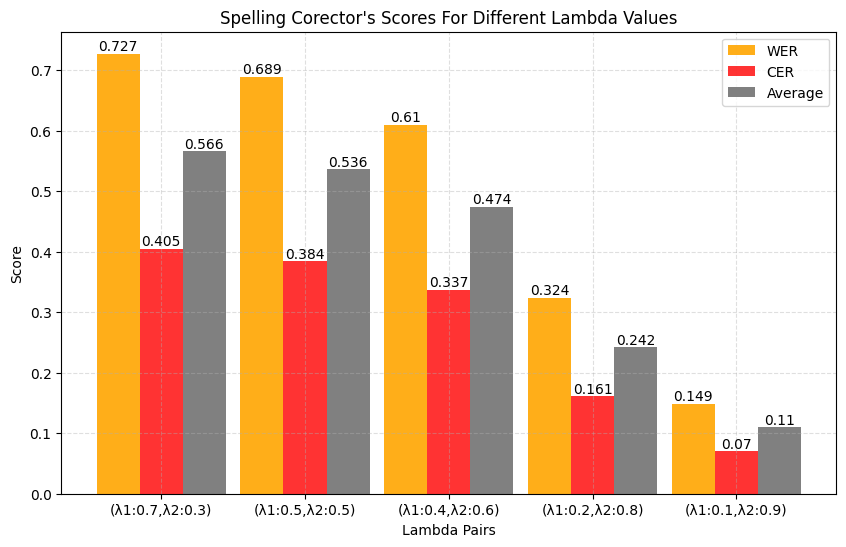

In [23]:
# Getting the values of x-axis
x_values = list(lambda_pairs_score.keys())

# Initializing the lists to keep the bar values
bar1_values, bar2_values, bar3_values = [], [], []

# Iterating over the dictionary
for value in lambda_pairs_score.values():

    # Updating
    bar1_values.append(value[0])
    bar2_values.append(value[1])
    bar3_values.append(round(np.mean(value), 3))

# Defining bars width and x-axis positions
bar_width = 0.3
x_posititons = np.arange(len(x_values))

# Creating the plot
plt.figure(figsize=(10, 6))

# Adding the bars
wer_bars = plt.bar(
    x_posititons - bar_width,
    bar1_values,
    width=bar_width,
    label="WER",
    alpha=0.9,
    color="orange",
)
cer_bars = plt.bar(
    x_posititons, bar2_values, width=bar_width, label="CER", alpha=0.8, color="red"
)
average_bars = plt.bar(
    x_posititons + bar_width,
    bar3_values,
    width=bar_width,
    label="Average",
    color="grey",
)

# Iterating over the different type of bars
for bars in [wer_bars, cer_bars, average_bars]:

    # Iterating over the bars of a specific type
    for bar in bars:

        # Getting the height/value
        height = bar.get_height()

        # Adding the value on top of the bar
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            str(height),
            ha="center",
            va="bottom",
            fontsize=10,
        )

# Adding plot elements
plt.xlabel("Lambda Pairs")
plt.ylabel("Score")
plt.title("Spelling Corector's Scores For Different Lambda Values")
plt.xticks(x_posititons, x_values)
plt.grid(True, which="both", linestyle="--", linewidth=0.8, alpha=0.4)
plt.legend()

# Showing the plot
plt.show()

As we can see from the bar chart above, the lambda pair that performs best on the spelling corrector is λ1=0.1 and λ2=0.9 where λ1 expresses how much the language model affects the spelling corrector and λ2 how much the Levenshtein distances affect it respectively

Test the spelling corrector on the test dataset of misspelled sentences

In [24]:
# Getting the join of the tokens of each test sentence
joined_test_sentences = [
    " ".join(sentence) for sentence in test_sentences_spelling_corrector
]

# Getting the join of the tokens of each noisy test sentence
joined_noisy_test_sentences = [
    " ".join(sentence) for sentence in noisy_test_sentences_spelling_corrector
]

# Initializing a list to keep the corrected sentences
corrected_test_sentences = []

# Iterating over the test noisy sentences
for sentence in noisy_test_sentences_spelling_corrector:

    # Applying the spelling corrector
    corrected_test_sentences.append(
        apply_spelling_corrector(
            sentence,
            vocb,
            vocb_size,
            4,
            0.1,
            0.9,
            best_bigram_alpha_parameter,
            best_trigram_alpha_parameter,
            unigrams_frequency,
            bigrams_frequency,
            trigrams_frequency,
            4,
        )
    )

# Computing the scores
scores = evaluate_spelling_corrector(corrected_test_sentences, joined_test_sentences)

Show the results

In [25]:
# Creating a table showing the performance of the spelling corrector

# Creating table values
table_1_data = [[scores[0], scores[1], round(np.mean(scores), 3)]]

# Creating the columnn names
table_1_headers = [
    f"{header:^70}"
    for header in ["\033[1mWER\033[0m", "\033[1mCER\033[0m", "\033[1mAverage\033[0m"]
]

# Creating a table showing how the spelling corrector corrects the sentences

# Creating table values
table_2_data = list(
    zip(joined_test_sentences, joined_noisy_test_sentences, corrected_test_sentences)
)

# Creating the columnn names
table_2_headers = [
    f"{header:^70}"
    for header in [
        "\033[1mOriginal Test Sentences\033[0m",
        "\033[1mNoisy Test Sentences\033[0m",
        "\033[1mCorrected Test Sentences\033[0m",
    ]
]

print(f"\033[1m{'Scores of Spelling Corrector':^200}\033[0m")
print()
print(tabulate(table_1_data, headers=table_1_headers, tablefmt="rounded_grid"))
print()
print(f"\033[1m{'Spelling Corrector on Test Dataset':^200}\033[0m")
print()
print(tabulate(table_2_data, headers=table_2_headers, tablefmt="rounded_grid"))

                                                                                      Scores of Spelling Corrector                                                                                      

╭──────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────╮
│                                WER                               │                                CER                               │                              Average                             │
├──────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────┤
│                                                             0.12 │                                                             0.05 │                                                      